# AGN PSD slopes in the time domain
## and their Gaussian Process kernel counterparts

M. Gully-Santiago  
July 12, 2019
Kepler/K2 GO Office

In this Jupyter notebook we explore the AGN PSD slopes and their Gaussian Process kernel counterparts.

In [1]:
import numpy as np
from astropy.io import fits
import copy
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.timeseries import LombScargle

In [2]:
import scope
import lightkurve as lk
import everest

In [3]:
from nfft import nfft

Let's turn off `DEBUG` logging messages.

In [4]:
import logging 
mpl_logger = logging.getLogger('matplotlib') 
mpl_logger.setLevel(logging.WARNING) 
logging.basicConfig()
logging.getLogger().setLevel(logging.WARNING)

# AGN Power Law Slopes


<img width=250 src=https://iopscience.iop.org/0004-637X/857/2/141/downloadFigure/figure/apjaab88df7 ></src>

From K. Smith et al. 2018, Section 5:
> The variability of AGN is a red noise process, meaning that successive samples are correlated in time. The power spectra of such processes are well described by a power law, where the spectral density S varies with the temporal frequency as:

$$ S \propto f^\alpha$$


K. Smith et al. find this histogram:

<img width=250 src=https://iopscience.iop.org/0004-637X/857/2/141/downloadFigure/figure/apjaab88df9></img>


First let's get genuine data to mimic the in-situ K2 motion properties as close as we can for a genuine source.

In [5]:
genuine_tpf = lk.search_targetpixelfile('EPIC 220182448', mission='K2', campaign=8).download()

You can use `genuine_tpf.interact()` to generate a *custom* aperture mask, **or** take the exact same mask as Everest.  Let's do the latter.  You can use `lc_Everest.dvs()` to see a data validation summary of the Everest data.

In [6]:
lc_Everest = everest.Everest(220182448, season=8, mission='k2')

INFO  [everest.user.DownloadFile()]: Found cached file.
INFO  [everest.user.load_fits()]: Loading FITS file for 220182448.


In [7]:
aperture_mask = lc_Everest.aperture.astype(np.bool)

In [8]:
lc = genuine_tpf.to_lightcurve(aperture_mask=aperture_mask)
n_cad, = lc.time.shape
n_cad

3595

# Modeling a range of PSD slopes with Gaussian Processes

## 1. Damped random walk

The Power Spectral Density (PSD) for a damped random walk resembles this form [(Uhlenbeck & Ornstein 1930)](http://adsabs.harvard.edu/abs/1930PhRv...36..823U):

$$S(\omega) = \sqrt{\frac{2}{\pi}}\,\frac{a}{c}\,
    \frac{1}{1+{\left(\frac{\omega}{c}\right)}^2} \quad$$
    
    
where we use $\omega = 2 \pi f$, the angular frequency.  This PSD has the Gaussian Process [(Foreman-Mackey et al. 2017)](https://ui.adsabs.harvard.edu/abs/2017AJ....154..220F/abstract) **kernel** $k$: 
$$k(\tau_{nm}) = a\,e^{\left(-c\,\tau_{nm}\right)}$$  

Note that in the limit of large frequencies ($f\rightarrow \infty$), the PSD is approximated as a power law with $\alpha=-2$:

$$\lim_{\omega \gg c} S(\omega) \rightarrow \sqrt{\frac{2}{\pi}}\,\frac{a}{c}\,
    \left(\frac{\omega}{c}\right)^{-2} \quad$$
    
We can set $c$ through a desire to have a powerlaw slope through the entire observation window:

$$c \gtrsim2 \pi \frac{1}{T_{K2}}$$

Let's set the characteristic time scale as 0.1 years.





## 2. Critically damped, stochastically driven Simple Harmonic Oscillator

A critically damped, stochastically driven Simple Harmonic Oscillator has no oscillatory behavior.  It's "quality factor", $Q$ has a value $1/\sqrt{2}$, leading to a power spectral density:

$$S(\omega) = \sqrt{\frac{2}{\pi}}\,\frac{S_0}{(\omega/\omega_0)^4+1}$$

In the limit of large frequencies ($f\rightarrow \infty$), the PSD is approximated as a power law with $\alpha=-4$:

$$\lim_{\omega \gg \omega_0} S(\omega) \rightarrow \sqrt{\frac{2}{\pi}}\, S_0\,
    \left(\frac{\omega}{\omega_0}\right)^{-4} \quad$$
    
It has the Gaussian Process kernel:

$$k(\tau) = S_0\,\omega_0\,e^{-\frac{1}{\sqrt{2}}\,\omega_0\,\tau}\,
    \cos{\left(\frac{\omega_0\,\tau}{\sqrt{2}}-\frac{\pi}{4}\right)} $$
    
We can also set $\omega_0$ through a desire to have a powerlaw slope through most of the observation window:

$$\omega_0 \gtrsim2 \pi \frac{1}{T_{K2}}$$

Let's set the characteristic time scale as 0.1 years (36 days).

In [9]:
(0.03*u.year).to(u.day)

<Quantity 10.9575 d>

In [10]:
t_char = (0.03*u.year).to(u.second)
omega_0_val = 2.0*np.pi * 1/(t_char)
omega_0_val.to(u.Hz) # units of Hz

<Quantity 6.63673759e-06 Hz>

What about the value of $S_0$?  It should have units of dimensionless power: what is the power at frequency $\omega=0$.

In [11]:
S0_val = 1e8 
S0_val

100000000.0

## Simulate the noise-free PSD with `celerite`

We follow the PSD normalization example from the [celerite documentation](https://celerite.readthedocs.io/en/stable/tutorials/normalization/).

In [12]:
from astropy.timeseries import LombScargle
import celerite
from celerite import terms

Note that celerité follows the numpy convention of **natural logs** $\ln{}$ for all $\log{}$ functions, unless explicitly providing base 10.

>Args:  
    - log_S0 (float): The log of the parameter `S_0`.
    - log_Q (float): The log of the parameter `Q`.
    - log_omega0 (float): The log of the parameter `omega_0`.

In [13]:
true_log_Q = np.log(1/np.sqrt(2.)) 
true_log_omega0 = np.log(omega_0_val.value) 
true_log_S0 = np.log(S0_val)

In [28]:
kernel_SHO = terms.SHOTerm(log_Q=true_log_Q, log_S0=true_log_S0, log_omega0=true_log_omega0) 
kernel = kernel_SHO

In [15]:
gp = celerite.GP(kernel, mean=3200, fit_mean=True)

In [16]:
# Simulate K datasets with N points
#t = (lc.time*u.day).to(u.second).value

# For even spacing for now:
t = (np.arange(lc.time[0],lc.time[-1], lc.time[1]-lc.time[0])*u.day).to(u.second).value
t = t - t[0]

In [17]:
t

array([0.00000000e+00, 1.76535316e+03, 3.53070633e+03, ...,
       6.79484433e+06, 6.79660968e+06, 6.79837503e+06])

In [18]:
len(t), n_cad

(3852, 3595)

In [19]:
gp.compute(t)

In [20]:
np.random.seed(42)
NN = n_cad
KK = 500
y = gp.sample(size=KK)

y.shape

(500, 3852)

We *do not* have evenly spaced frequencies, so we technidally shouldn't use the numpy implementation of FFT from the celerite example.  Instead we should use the `NFFT` algorithm:
https://github.com/jakevdp/nfft  
This algorithm requires some extra preprocessing and tuning, so I will leave that as an exercise for the future.

In [21]:
# Compute the FFT based power spectrum estimates
f = np.fft.rfftfreq(len(t), t[1] - t[0])
fft = np.array(list(map(np.fft.rfft, y)))
fft *= np.conj(fft)

# >>> To get the FFT based PSD in the correct units, normalize by N^2 <<<
power_fft = fft.real / NN**2

In [22]:
# Compute the LS based power spectrum estimates
power_ls = []
for y0 in y:
    model = LombScargle(t, y0)
    power_ls.append(model.power(f[1:-1], method="fast", normalization="psd"))
power_ls = np.array(power_ls)

# >>> To get the LS based PSD in the correct units, normalize by N <<<
power_ls /= NN

In [23]:
# Compute the true power spectrum
# NOTE: the 2*pi enters because celerite computes the PSD in _angular_ frequency
power_true = kernel.get_psd(2*np.pi*f)

# >>> To get the true PSD in units of physical frequency, normalize by 2*pi <<<
power_true /= 2*np.pi

In [24]:
fake_omega = np.logspace(-6, -4, base=10)
fake_pow = fake_omega**(-4) / 5e19

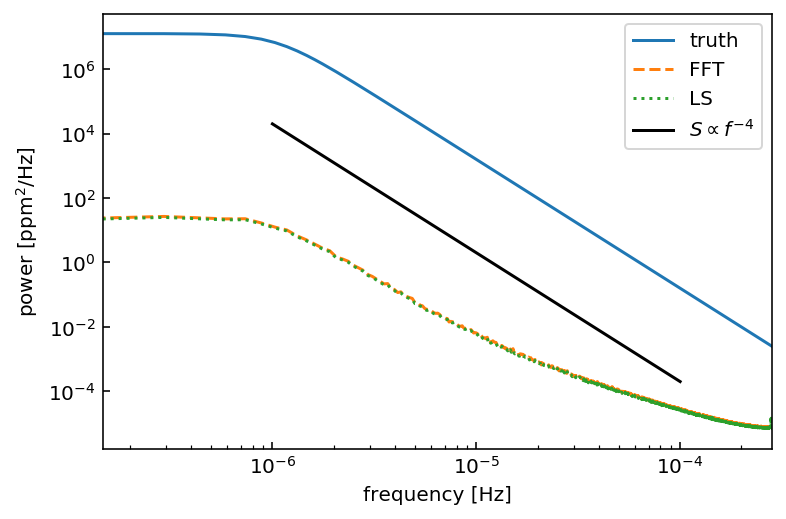

In [25]:
# Let's plot the estimates of the PSD
plt.figure()
#plt.plot(f, power_true, label="truth")
plt.plot(f, power_true, label="truth")
#plt.plot(f, analytic_power, label='analytic')
plt.plot(f, np.median(power_fft, axis=0), "--", label="FFT")
plt.plot(f[1:-1], np.median(power_ls, axis=0), ":", label="LS")
plt.yscale("log")
plt.xscale("log")
plt.xlim(f[1:].min(), f.max())
plt.ylabel("power [$\mathrm{ppm}^2/\mathrm{Hz}$]")
plt.xlabel("frequency [Hz]")

plt.plot(fake_omega, fake_pow, 'k-', label='$S \propto f^{-4}$')

plt.legend();

The normalization scale still diverges for [unknown reasons](https://github.com/dfm/celerite/issues/140), as we saw, but even more alarmingly, we see extra power at high frequencies.  I think this effect stems from numerical issues / finite window effects.

In [26]:
simulated_signal = y[9, :]

plt.figure(figsize=(22, 5))
plt.plot(lc.time-lc.time[0], lc.flux, label='RAW')
plt.plot(t/60/60/24 , simulated_signal, label='Simulated')
plt.ylim(3140, 3280)
plt.title('EPIC {}'.format(lc.targetid))
plt.xlabel('time (days)')
plt.ylabel('flux (e/s)')
plt.legend();

A signal with the simulated amplitude could plausibly reside in the data, at just below the signal-to-noise ratio to detect by eye.  The synthetic lightcurve is much smoother than the $\alpha=-2$ damped random walk, which makes sense.

## 3. Broken power law: sum of two kernels

Here we explore the sum of two kernels: a critically damped SHO, *plus* a damped random walk (DRW).


$$k_{net}(\tau) = k_{DRW} + k_{SHO} $$
    
We will add kernels with the same properties as previous simulations.

In [51]:
t_char_RW = (0.1*u.year).to(u.second)
c_val = 2.0*np.pi * 1/(t_char_RW)
c_val.to(u.Hz) # units of Hz

<Quantity 1.99102128e-06 Hz>

In [71]:
a_val = c_val*3e7
true_logc, true_loga = np.log(c_val.value) , np.log(a_val.value)

In [54]:
kernel_DRW = terms.RealTerm(log_a=true_loga, log_c=true_logc) 

In [55]:
kernel = kernel_DRW + kernel_SHO

In [56]:
gp = celerite.GP(kernel, mean=3200, fit_mean=True)
gp.compute(t)
y = gp.sample(size=KK)

In [57]:
# Compute the FFT based power spectrum estimates
f = np.fft.rfftfreq(len(t), t[1] - t[0])
fft = np.array(list(map(np.fft.rfft, y)))
fft *= np.conj(fft)

# >>> To get the FFT based PSD in the correct units, normalize by N^2 <<<
power_fft = fft.real / NN**2

# Compute the LS based power spectrum estimates
power_ls = []
for y0 in y:
    model = LombScargle(t, y0)
    power_ls.append(model.power(f[1:-1], method="slow", normalization="psd"))
power_ls = np.array(power_ls)

# >>> To get the LS based PSD in the correct units, normalize by N <<<
power_ls /= NN

# Compute the true power spectrum
# NOTE: the 2*pi enters because celerite computes the PSD in _angular_ frequency
power_true = kernel.get_psd(2*np.pi*f)

# >>> To get the true PSD in units of physical frequency, normalize by 2*pi <<<
power_true /= 2*np.pi

fake_omega = np.logspace(-6, -4, base=10)
fake_pow = fake_omega**(-2) / 1e9

/Users/obsidian/anaconda3/envs/scope_dev/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  


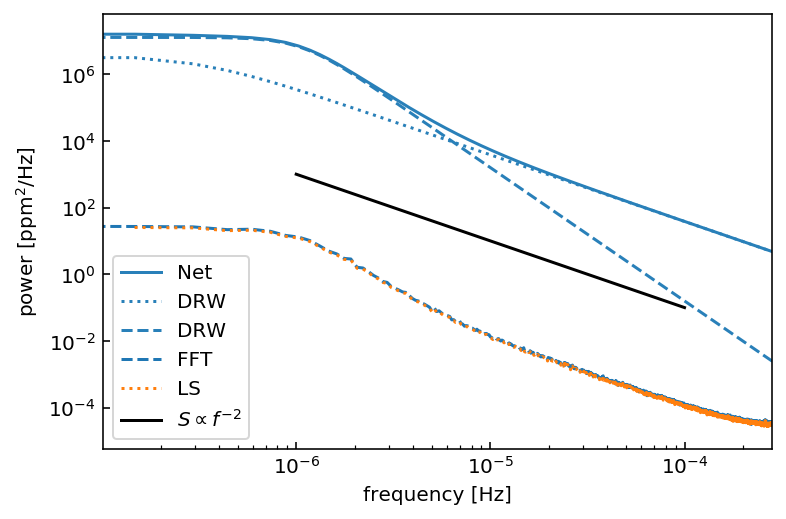

In [58]:
# Let's plot the estimates of the PSD
plt.figure()
#plt.plot(f, power_true, label="truth")
plt.plot(f, power_true, label="Net", color='#2980b9')
plt.plot(f, kernel_DRW.get_psd(2*np.pi*f)/(2*np.pi), label="DRW", color='#2980b9', linestyle=':')
plt.plot(f, kernel_SHO.get_psd(2*np.pi*f)/(2*np.pi), label="DRW", color='#2980b9', linestyle='--')


#plt.plot(f, analytic_power, label='analytic')
plt.plot(f, np.median(power_fft, axis=0), "--", label="FFT")
plt.plot(f[1:-1], np.median(power_ls, axis=0), ":", label="LS")
plt.yscale("log")
plt.xscale("log")
plt.xlim(f.min(), f.max())
plt.ylabel("power [$\mathrm{ppm}^2/\mathrm{Hz}$]")
plt.xlabel("frequency [Hz]")

plt.plot(fake_omega, fake_pow, 'k-', label='$S \propto f^{-2}$')

plt.legend()

It works!  But the kink is concave-up.

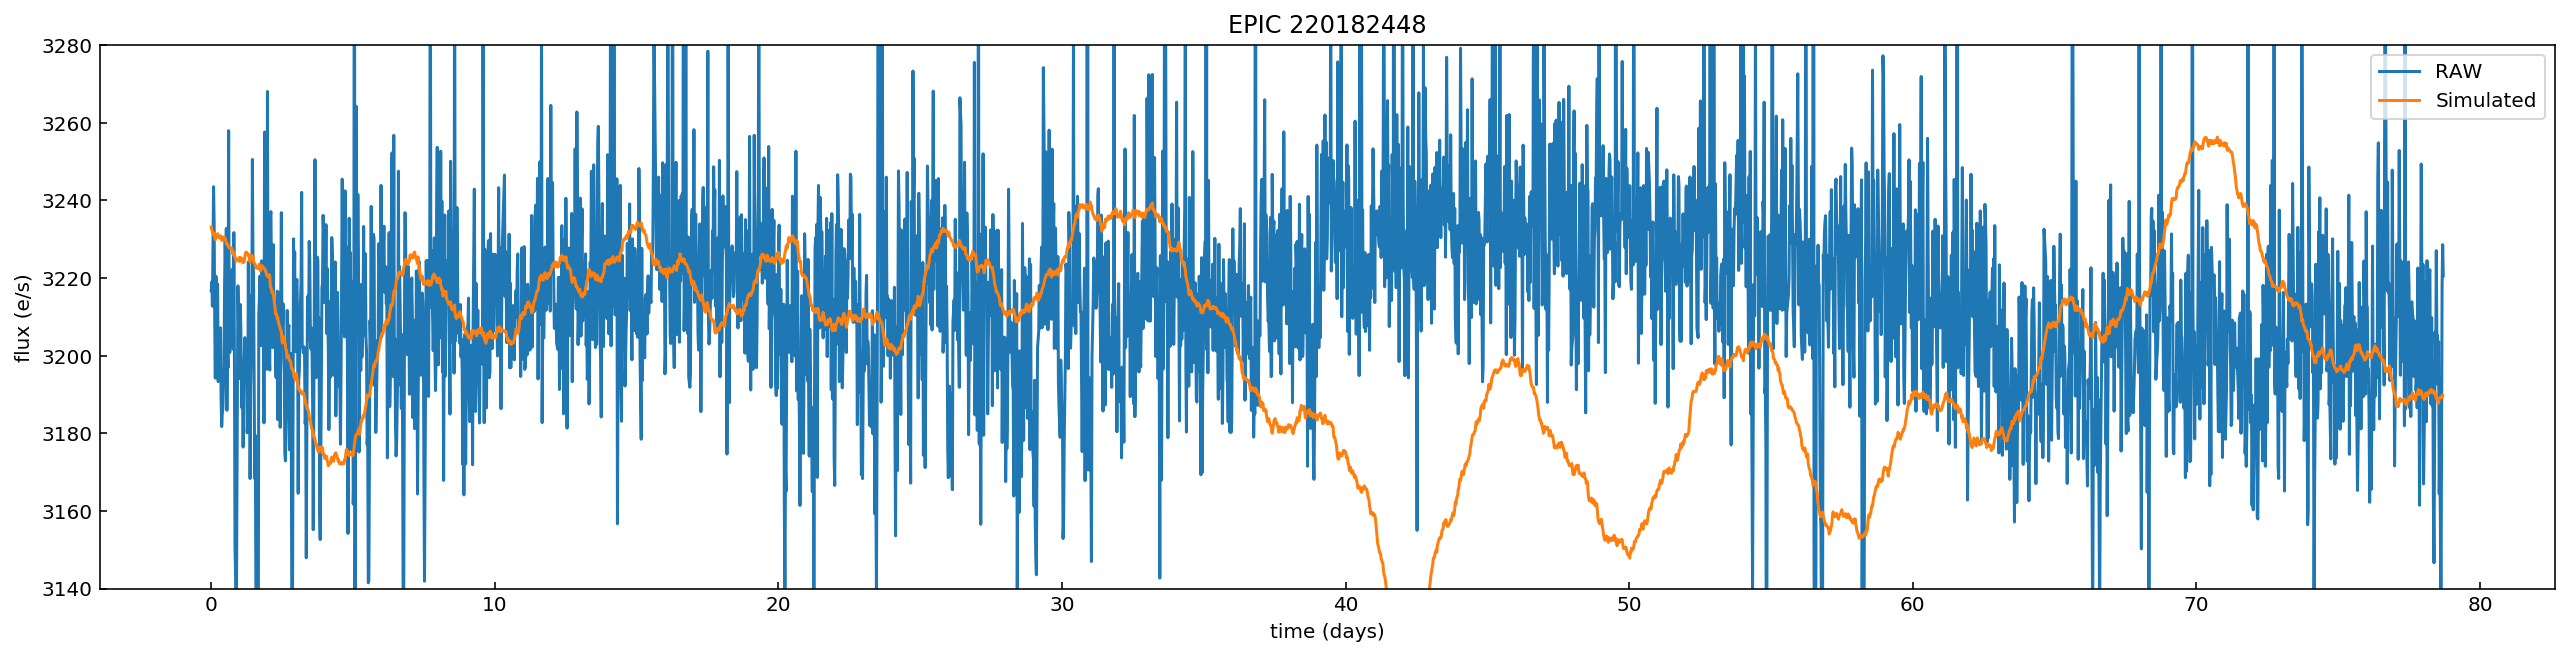

In [59]:
simulated_signal = y[9, :]

plt.figure(figsize=(22, 5))
plt.plot(lc.time-lc.time[0], lc.flux, label='RAW')
plt.plot(t/60/60/24 , simulated_signal, label='Simulated')
plt.ylim(3140, 3280)
plt.title('EPIC {}'.format(lc.targetid))
plt.xlabel('time (days)')
plt.ylabel('flux (e/s)')
plt.legend();

## 4. Broken power law: product of two kernels

Here we explore the product of two kernels: a critically damped SHO, *times* a damped random walk (DRW).


$$k_{net}(\tau) = k_{DRW} \cdot k_{SHO} $$
    
We will multiply kernels with the same properties as previous simulations.

In [72]:
a_val = c_val
true_logc, true_loga = np.log(c_val.value) , np.log(a_val.value)

In [73]:
kernel_DRW = terms.RealTerm(log_a=true_loga, log_c=true_logc) 

In [74]:
kernel = kernel_DRW * kernel_SHO

In [75]:
gp = celerite.GP(kernel, mean=3200, fit_mean=True)
gp.compute(t)
y = gp.sample(size=KK)

In [76]:
# Compute the FFT based power spectrum estimates
f = np.fft.rfftfreq(len(t), t[1] - t[0])
fft = np.array(list(map(np.fft.rfft, y)))
fft *= np.conj(fft)

# >>> To get the FFT based PSD in the correct units, normalize by N^2 <<<
power_fft = fft.real / NN**2

# Compute the LS based power spectrum estimates
power_ls = []
for y0 in y:
    model = LombScargle(t, y0)
    power_ls.append(model.power(f[1:-1], method="slow", normalization="psd"))
power_ls = np.array(power_ls)

# >>> To get the LS based PSD in the correct units, normalize by N <<<
power_ls /= NN

# Compute the true power spectrum
# NOTE: the 2*pi enters because celerite computes the PSD in _angular_ frequency
power_true = kernel.get_psd(2*np.pi*f)

# >>> To get the true PSD in units of physical frequency, normalize by 2*pi <<<
power_true /= 2*np.pi

fake_omega = np.logspace(-6, -4, base=10)
fake_pow = fake_omega**(-2) / 1e9

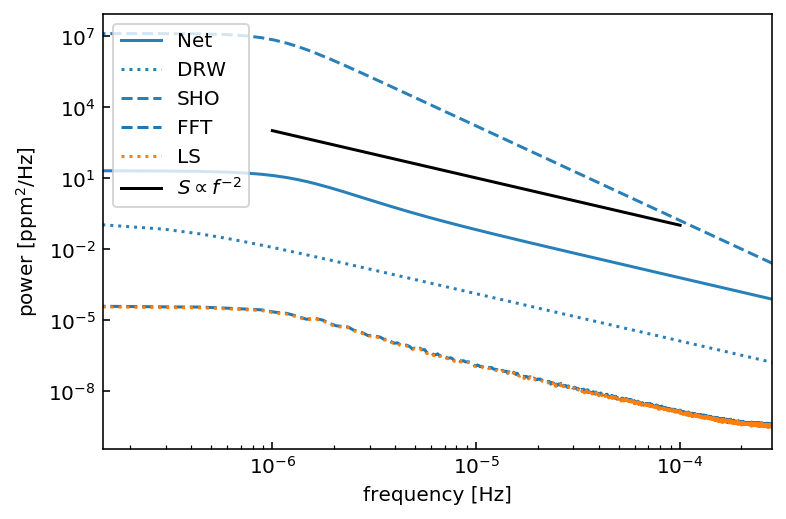

In [77]:
# Let's plot the estimates of the PSD
plt.figure()
#plt.plot(f, power_true, label="truth")
plt.plot(f, power_true, label="Net", color='#2980b9')
psd_drw = kernel_DRW.get_psd(2*np.pi*f)/(2*np.pi)
psd_sho = kernel_SHO.get_psd(2*np.pi*f)/(2*np.pi)
plt.plot(f, psd_drw, label="DRW", color='#2980b9', linestyle=':')
plt.plot(f, psd_sho, label="SHO", color='#2980b9', linestyle='--')

#plt.plot(f, analytic_power, label='analytic')
plt.plot(f, np.median(power_fft, axis=0), "--", label="FFT")
plt.plot(f[1:-1], np.median(power_ls, axis=0), ":", label="LS")
plt.yscale("log")
plt.xscale("log")
plt.xlim(f[1:].min(), f.max())
plt.ylabel("power [$\mathrm{ppm}^2/\mathrm{Hz}$]")
plt.xlabel("frequency [Hz]")

plt.plot(fake_omega, fake_pow, 'k-', label='$S \propto f^{-2}$')

plt.legend()

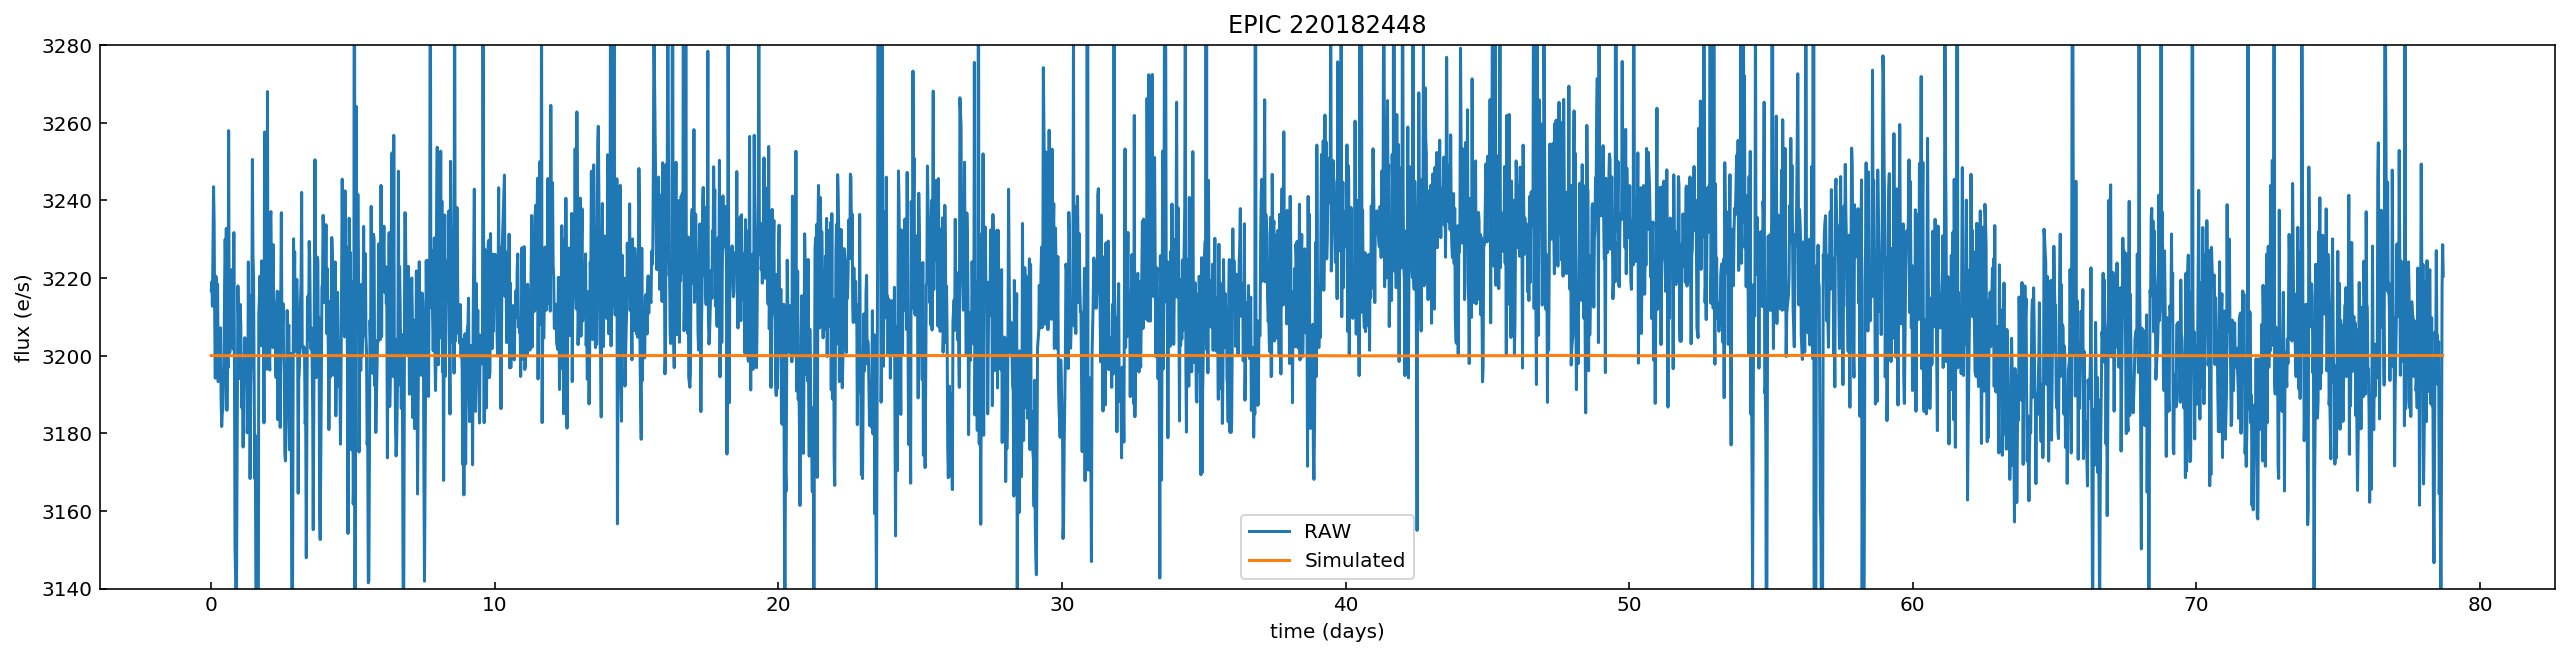

In [78]:
simulated_signal = y[9, :]

plt.figure(figsize=(22, 5))
plt.plot(lc.time-lc.time[0], lc.flux, label='RAW')
plt.plot(t/60/60/24 , simulated_signal, label='Simulated')
plt.ylim(3140, 3280)
plt.title('EPIC {}'.format(lc.targetid))
plt.xlabel('time (days)')
plt.ylabel('flux (e/s)')
plt.legend();

Whoops, need to increase the overall amplitude.